<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINN_method_for_1D_Burgers'_equation_inverse_problem_plus_experiments_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import required libraries and tools
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import pandas as pd

from time import perf_counter

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

!git clone https://github.com/SciCoLab/PINNs.git &> /dev/null 

import sys
sys.path.append('/content/PINNs')
import utilityFunctions
import physicsInformedNeuralNetworks

# connect to google drive for storing results
# from google.colab import drive
# drive.mount('/content/gdrive')

## Finite difference solver

In [3]:
# solves 1D Burgers' equations using devito finite difference computation
def devitoSolver_1D_Burgers(tResolution, xResolution, tMin, tMax, xMin, xMax, l1, l2):
    # define discretisation
    # extent x direction
    extent_x = xMax - xMin
    # number of x grid points
    nx = xResolution
    # x direction step size
    dx = extent_x / (nx - 1)
    # time extent (total duration)
    T = tMax - tMin
    # time step
    dt = 1e-4
    # number of time points
    nt = int(T / dt)

    # create 1D grid and assign dimension variable names
    grid = Grid(shape=(nx), extent=(extent_x))
    x = grid.dimensions
    t = grid.stepping_dim
    # create time function on grid
    # space order of 2 to enable 2nd derivative
    u = TimeFunction(name='u', grid=grid, space_order=2)
    # create constant (viscosity)
    a = Constant(name='a')
    b = Constant(name='b')
    # define 1D Burgers' equation
    equation_u = Eq(u.dt + a*u*u.dxl, b*u.dx2)
    # create stencil by solving for next time step
    stencil_u = solve(equation_u, u.forward)
    # define equation for next time step
    update_u = Eq(u.forward, stencil_u)
    # define boundary conditions
    # u = 0 at min and max extent of x
    boundaryConditions = [Eq(u[t+1, 0], 0.)]
    boundaryConditions += [Eq(u[t+1, nx], 0.)]
    # define operator based on equation and boundary conditions
    op = Operator([update_u] + boundaryConditions)

    # set solution space to 0s
    u.data[:] = 0
    # create a dummy x array from -1 to +1
    dummyX = np.arange(-1, 1+dx, dx)
    # set initial conditions using dummy x array
    u.data[0] = -1 * np.sin(np.pi * dummyX)

    # define number of time steps to compute before storing result
    batchSize = int(nt/tResolution)

    # initialise empty array to store computed solution
    results = np.zeros((nx, tResolution))
    # store initial conditions in results array
    results[:,0] = u.data[0].copy()

    # log start time to measure performance
    startTime = perf_counter()

    # iterate over result steps
    # start from 1 not 0 as results at step 0 are the initial conditions
    for timeStep in range(1, tResolution):
        # compute solution after batchSize time steps
        summary = op.apply(time=batchSize, dt=dt, a=l1, b=l2)
        # store computed solution in results array
        results[:,timeStep] = u.data[0].copy()

    # record computation time
    duration = perf_counter()-startTime

    return results, duration

## Training data generator

In [4]:
def dataGenerator_1D_BurgersInverse(FD_solution, N):
    # create empty array
    trainingArray = np.zeros((N, 3))
    # randomly select t and x indices
    tIdxArray = rng.choice(FD_solution.shape[1], size=N)
    xIdxArray = rng.choice(FD_solution.shape[0], size=N)
    # update training array with real values and t and x
    trainingArray[:,0] = tIdxArray / FD_solution.shape[1]
    trainingArray[:,1] = ((xIdxArray / FD_solution.shape[0]) * 2) - 1.
    # upate training array with solution values from finite difference solution array
    trainingArray[:,2] = FD_solution[xIdxArray, tIdxArray]
    return trainingArray

## Setup:
* Problem domain
* FD solution

In [ ]:
# define spatial and temporal domain extent
xMin = -1
xMax = 1
tMin = 0
tMax = 1

# define coefficients
l1 = 1.
l2 = 0.01/np.pi

# compute finite difference solution
FD_solution, FD_duration = devitoSolver_1D_Burgers(1000, 1000, tMin, tMax, xMin, xMax, l1, l2)

## Load experimental results csv

In [9]:
# dummy test number so plotting code works
testNumber = -10

In [6]:

# load experiment results and update current test number
# inverseResults=pd.read_csv('/content/gdrive/My Drive/pinns/1dBurgers_inv_results.csv', index_col=0)
# testNumber = inverseResults.shape[0]+1
# testNumber

## Define PINN and noise corruption

In [7]:
N = 8000 # number training points: 1000, 2000, 4000, 8000
noise = 0 # percent: 0, 2, 4, 8

NArray = dataGenerator_1D_BurgersInverse(FD_solution, N)
addedNoise = rng.normal(0, 1, NArray.shape[0]) * NArray[:,-1].max() * (noise/100)
NArray[:,-1] = NArray[:,-1] + addedNoise

# define network characteristics
hiddenLayers = 7
nodesPerLayer = 20
activationFunction = nn.Tanh()
maxIterations = 50000
maxEvaluations = 500000
l1_init = 0.
l2_init = -6.
inverseProblem = True

# create network and print number of trainable parameters
model = physicsInformedNeuralNetworks.PINN_1D_Burgers(hiddenLayers, nodesPerLayer, activationFunction, maxIterations, maxEvaluations, l1_init, l2_init, inverseProblem)
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

Network parameters: 3023


## Perform training

In [8]:
# train model
model.trainer(NArray, NArray[:,:-1])

# get final coefficient approximations
l1Pred = model.lxHistory[-1,0]
l2Pred = model.lxHistory[-1,1]

# compute coefficient errors
l1Err = 100 * abs(l1Pred - l1) / l1
l2Err = 100 * abs(l2Pred - l2) / l2

Epoch: 1 --- Elapsed time: 0.32s --- Loss: 0.45705318450927734
Epoch: 2 --- Elapsed time: 0.45s --- Loss: 0.4039955139160156
Epoch: 4 --- Elapsed time: 0.71s --- Loss: 0.37566855549812317
Epoch: 8 --- Elapsed time: 1.22s --- Loss: 0.36126869916915894
Epoch: 16 --- Elapsed time: 2.22s --- Loss: 0.27967262268066406
Epoch: 32 --- Elapsed time: 4.24s --- Loss: 0.054084066301584244
Epoch: 64 --- Elapsed time: 8.27s --- Loss: 0.027096712961792946
Epoch: 128 --- Elapsed time: 16.40s --- Loss: 0.018520155921578407
Epoch: 256 --- Elapsed time: 33.73s --- Loss: 0.014732664451003075
Epoch: 500 --- Elapsed time: 65.15s --- Loss: 0.0086554866284132
Epoch: 1000 --- Elapsed time: 128.45s --- Loss: 0.000818840111605823
Epoch: 1500 --- Elapsed time: 191.39s --- Loss: 0.0003402615839149803
Epoch: 2000 --- Elapsed time: 254.37s --- Loss: 0.00014164576714392751
Epoch: 2500 --- Elapsed time: 317.47s --- Loss: 7.236067904159427e-05
Epoch: 3000 --- Elapsed time: 380.56s --- Loss: 4.101915692444891e-05
Epoch:

## Loss curves

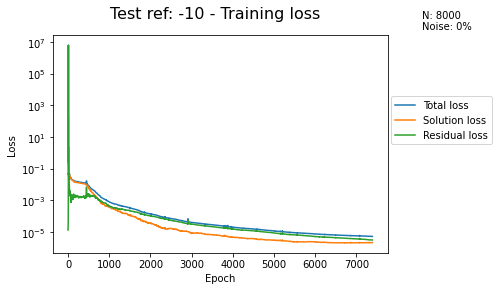

In [10]:
# plot training loss curves
fig = utilityFunctions.trainingHistoryPlot(model.history, ['Total loss', 'Solution loss', 'Residual loss'], 'Loss', f"Test ref: {testNumber} - Training loss", yLogAx=True)
fig.text(0.98, 0.9, f'N: {N}\nNoise: {noise}%')

# fig.savefig(f"/content/gdrive/My Drive/pinns/Test ref: {testNumber} - Loss curve", bbox_inches='tight')
plt.show()

## Learned coefficient plots


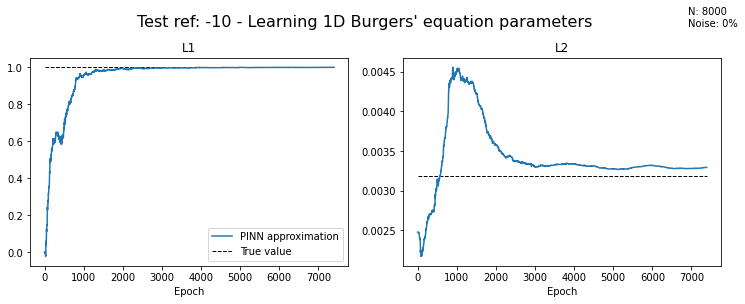

In [11]:
fig, [l1Ax, l2Ax] = plt.subplots(1,2,
    figsize=(10, 4),
    constrained_layout=True,
    )

l1Ax.plot(model.lxHistory[:,0],
          label='PINN approximation')
l1Ax.hlines(y=l1, xmin=0, xmax=model.lxHistory.shape[0], color='k', linestyle='dashed', linewidth=1,
            label='True value')
l1Ax.set_title('L1')
l1Ax.set_xlabel('Epoch')

l1Ax.legend()

l2Ax.plot(model.lxHistory[:,1])
l2Ax.hlines(y=l2, xmin=0, xmax=model.lxHistory.shape[0], color='k', linestyle='dashed', linewidth=1) 
l2Ax.set_title('L2')
l2Ax.set_xlabel('Epoch')

fig.suptitle(f"Test ref: {testNumber} - Learning 1D Burgers' equation parameters", fontsize=16)

fig.text(0.95, 0.95, f'N: {N}\nNoise: {noise}%')

# fig.savefig(f"/content/gdrive/My Drive/pinns/Test ref: {testNumber} - Learning 1D Burgers' equation parameters", bbox_inches='tight')

plt.show()

## Generate solution and compute error

In [12]:
# compute meshgrid, solution and residual
# arguments: (model, xDim, yDim, xMin, xMax, yMin, yMax, xArg, yArg, residual=True)
mesh_x, mesh_y, PINN_solution, PINN_residual = utilityFunctions.create2dMeshData_1dBurgers(model, 1000, 1000, 0, 1, -1, 1, 't', 'x', residual=True)
relativeErr2 = np.linalg.norm(FD_solution-PINN_solution, 2) / np.linalg.norm(FD_solution, 2)
relativeErr2

0.0017079881444495306

## Solution and residual plots

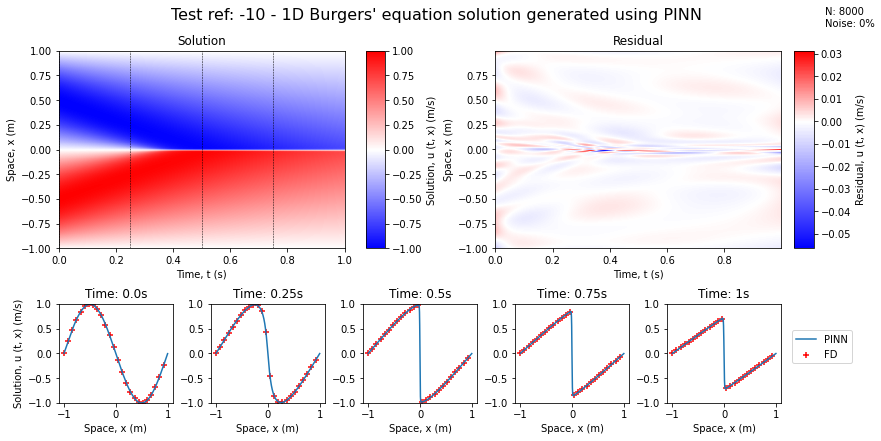

In [13]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(mesh_x, mesh_y, PINN_solution, cmap='bwr', vmin=-1, vmax=1)
solutionAx.set_xlim([0, 1])
solutionAx.set_ylim([-1, 1])

solutionAx.set_title('Solution')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# add residual plot
residualAx = fig.add_subplot(gs[:2,10:])
norm = TwoSlopeNorm(vcenter=0)
residualPlot = residualAx.pcolormesh(mesh_x, mesh_y, PINN_residual, cmap='bwr', norm=norm)
residualAx.set_title('Residual')
residualAx.set_xlabel('Time, t (s)')
residualAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(residualPlot, use_gridspec=True)
cbar.set_label('Residual, u (t, x) (m/s)')

markEvery = np.arange(0, FD_solution.shape[1], 40)

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(mesh_y[:, i*(mesh_y.shape[1]//4)], PINN_solution[:, i*(mesh_y.shape[1]//4)])

        tPlot.scatter(mesh_y[:, i*(mesh_y.shape[1]//4)][markEvery], FD_solution[:, i*(mesh_y.shape[1]//4)][markEvery],
                      s=40,
                      c='red',
                      marker='+',
                      )

        tPlot.set_title('Time: ' + str(i*mesh_x[0, mesh_x[0].shape[0]//4]) + 's')
        # add vertical lines to solution plot to indicate snapshots
        solutionAx.vlines(x=i*mesh_x[0, mesh_x[0].shape[0]//4], ymin=mesh_y[0,0], ymax=mesh_y[-1,0], colors='black', ls='--', lw=0.5)
    else:
        tPlot.plot(mesh_y[:, -1], PINN_solution[:, -1],
                   label='PINN',
                   )

        tPlot.scatter(mesh_y[:, -1][markEvery], FD_solution[:, -1][markEvery],
                      s=40,
                      c='red',
                      marker='+',
                      label='FD',
                      )
        
        tPlot.legend(loc=[1.1, 0.4])

        tPlot.set_title('Time: ' + str(tMax) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

fig.text(0.95, 0.95, f'N: {N}\nNoise: {noise}%')
# figure title
fig.suptitle(f"Test ref: {testNumber} - 1D Burgers' equation solution generated using PINN", fontsize=16)

# fig.savefig(f"/content/gdrive/My Drive/pinns/Test ref: {testNumber} - 1D Burgers' solution - PINN", bbox_inches='tight')
plt.show()

## Store experimental results

In [14]:
# inverseResults = inverseResults.append({
#     'Test ref': testNumber,
#     'N': N,
#     'Noise %': noise,
#     'Terminating loss': model.history[-1,0],
#     'Solution error': relativeErr2,
#     'L1 error %': l1Err,
#     'L2 error %': l2Err,
#     },
#     ignore_index=True)

# inverseResults.to_csv('/content/gdrive/My Drive/pinns/1dBurgers_inv_results.csv')
# inverseResults

## Plot experiment results

In [15]:
# fig, [l1ErrAx, l2ErrAx] = plt.subplots(1, 2,
#                                        figsize=(10, 4),
#                                        constrained_layout=True
#                                        )
# xAxisLabels = 1000 * 2**np.arange(4)

# sns.lineplot(
#     ax=l1ErrAx,
#     data=inverseResults,
#     x='N',
#     y='L1 error %',
#     hue='Noise %',
#     palette='tab10',
#     legend = False,
# )
# l1ErrAx.set_title(r'$\lambda_{1}$')
# l1ErrAx.set_xlabel('Number of training points')
# l1ErrAx.set_ylabel('Relative error %')
# l1ErrAx.set_xscale('log')
# l1ErrAx.set_xticks(xAxisLabels)
# l1ErrAx.set_xticklabels(xAxisLabels)
# l1ErrAx.minorticks_off()

# sns.lineplot(
#     ax=l2ErrAx,
#     data=inverseResults,
#     x='N',
#     y='L2 error %',
#     hue='Noise %',
#     palette='tab10',
# )
# l2ErrAx.set_title(r'exp($\lambda_{2}$)')
# l2ErrAx.set_xlabel('Number of training points')
# l2ErrAx.set_ylabel('Relative error %')
# l2ErrAx.set_xscale('log')
# l2ErrAx.set_xticks(xAxisLabels)
# l2ErrAx.set_xticklabels(xAxisLabels)
# l2ErrAx.minorticks_off()

# fig.suptitle("Training points versus noise - impact on 1D Burgers' inverse problem", fontsize=16)

# # fig.savefig(f"/content/gdrive/My Drive/pinns/1D Burgers' inverse experiment: NvsNoise", bbox_inches='tight')
# plt.show()